<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>ASE: Total Variation Denoising</h2>
Semester 2, 2023<br>
</center>

In [1]:
import torch
from torch import optim
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [6]:
if torch.backends.mps.is_available():
    gpu_device = torch.device("mps")
    print(gpu_device, "is detected.")
elif torch.cuda.is_available():
    gpu_device = torch.device("cuda:0")
    print(gpu_device, "is detected.")
cpu_device = torch.device("cpu")

global_device = cpu_device
# global_device = gpu_device
print(global_device, "is used.")

mps is detected.
cpu is used.


## Total Variation Denoising
Total variation denoising is an effective technique for eliminating noise from a signal while maintaining its distinct features intact. The algorithm employed in total variation denoising facilitates the enhancement of signal smoothness and continuity. More precisely, this method revolves around the resolution of the subsequent optimization problem:
$$
\begin{aligned}

\text{minimize}_{u}  \quad f_{\lambda}(u,x)= \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i |

\end{aligned}
$$

Firstly, we will show a simple example of total variation denoising of a one dimensional signal by using stochastic gradient descent to minimize the objective function $f_{\lambda}(u,x)$ with $\lambda=2$

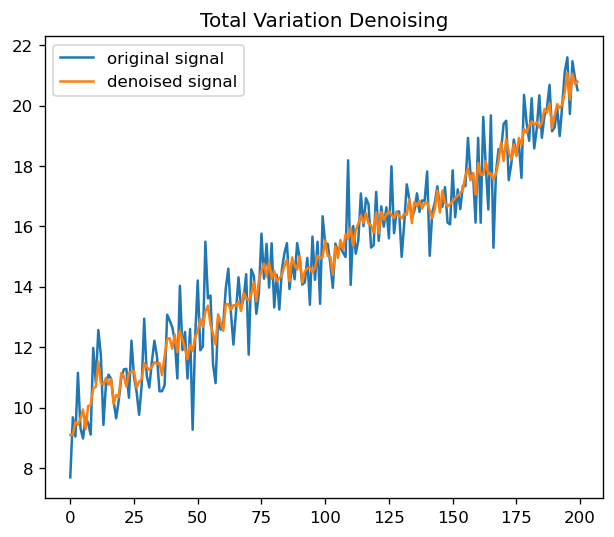

In [3]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd * torch.sum(torch.abs(u[1:]-u[:-1]))

# Simply implement
torch.manual_seed(0)
signal = torch.linspace(10, 20, 200) + torch.randn(200, dtype=torch.double)
lmd = 2
u = torch.nn.Parameter(signal.clone())
optimizer = optim.SGD([u], lr=0.1)
for _ in range(400):
    optimizer.zero_grad()
    loss = f(u, signal, lmd)
    loss.backward()
    optimizer.step()

plt.figure(figsize=(6,5), dpi=150)
plt.plot(signal.detach(), label="original signal")
plt.plot(u.detach(),      label="denoised signal")
plt.legend()
plt.title("Total Variation Denoising")
plt.show()

## Automatic Differentiation in Declarative Node
We can define a `TotalVariationFcn` class for automatic differentiation for a declarative node. Suppose $x$ is the input to the declarative node and $y(x)$ is the output of the node. We can define the following function:
$$f_{\lambda}(u,x)= \frac{1}{2}  \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i |$$
$$y(x)  = \operatorname{\text{argmin}}_u f(u,x)$$

<p align="center">
  <img src="https://github.com/yiran-frank-mao/COMP4680_ASE/blob/main/src/decNode.png?raw=1" width="1000">
</p>


By math derivation, we can get the following nice derivative:
$$\frac{\mathrm{d}y}{\mathrm{d}x} = \mathbf{I}$$
where $\mathbf{I}$ is the identity matrix.

In [2]:
def f(u, x, lmd):
    return 0.5 * torch.sum((u-x)**2) + lmd * torch.sum(torch.abs(u[1:]-u[:-1]))
    
def gradient(u, x, lmd):
   v = torch.roll(u,1);  v[0]=u[0]
   w = torch.roll(u,-1); w[-1]=u[-1]
   return u-x+lmd*(torch.sign(u-v)-torch.sign(w-u))

In [55]:
def lineSearch(f, df, x, dx, alpha=0.3, beta=0.7):
    """
    Backtracking line search.

    :param f: The function being optimized.
    :param df: Gradient of the function at x.
    :param x: Starting point for line search.
    :param dx: Direction of line search.
    :param alpha: Line search parameter for stopping criteria.
    :param beta: Line search parameter for reducing step size.
    :return: Step size t.
    """
    t = 1.0
    while f(x+t*dx).item() > (f(x)+alpha*t*dx@df.T).item():
        t *= beta
        
    return t

def gradient_descent(x, f, g, eps=1.0e-6, max_iters=200, alpha=0.3, beta=0.7, line_search=False, t=1.0e-3, gamma=1.0):
    """
    Gradient descent to minimize function f.
    
    :param x: Starting point in domain of f.
    :param f: The function to be optimized. Returns scalar.
    :param g: The gradient function. Returns vector in R^n.
    :param eps: Tolerance for stopping.
    :param max_iters: Maximum number of iterations for stopping.
    :param alpha: Backtracking line search parameter.
    :param beta: Backtracking line search parameter.
    :return: Optimization path (i.e., array of x's). The last point is the optimal point.
    """
    if line_search:
        for iter in range(max_iters):
            # Compute gradient
            dx = -1.0 * g(x)
            if torch.linalg.norm(dx) <= eps:
                break
            t = lineSearch(f, g(x), x, dx, alpha, beta)
            x += t * dx
    else:
        for iter in range(max_iters):
            dx = -g(x)/np.linalg.norm(g(x))
            if f(x+t*dx)!=torch.inf:
                x += t*dx
            t = gamma*t
    
    return x

In [35]:
class TotalVariationFcn(torch.autograd.Function):
    """PyTorch autograd function for total variation denoising."""

    @staticmethod
    def forward(ctx, x, lmd):
        with torch.no_grad():
            x_clone = x.detach()
            u = torch.nn.Parameter(x_clone, requires_grad=False)
            y = gradient_descent(u, lambda u: f(u, x_clone, lmd), lambda u: gradient(u, x_clone, lmd), line_search=True)
        return y

    @staticmethod
    def backward(ctx, dLdY):
        with torch.no_grad():
            dLdX = dLdY
        return dLdX, None

Check the gradient of the `TotalVariationFcn` class by using `gradcheck` function in PyTorch:

In [36]:
M = 15
fcn = TotalVariationFcn.apply

torch.manual_seed(4399)
X = torch.randn((1, M), dtype=torch.double, device=cpu_device, requires_grad=True)

test = gradcheck(fcn, (X, 0.2), eps=1e-6, atol=1e-3, rtol=1e-6)
print("Backward test of DiffPolyFitFcn: {}".format(test))

Backward test of DiffPolyFitFcn: True


## Bi-Level Optimization Example
To profile the code, set up the following bi-level optimisation problem where the lower level problem is the total variation denoising problem:
$$
\begin{aligned}
\textbf{minimize}     & \quad  \frac{1}{2} \|y^\star-y^{\text{target}}\|_2^2 \\
\textbf{subject to}   & \quad  y^\star = \mathrm{argmin}_u \frac{1}{2} * \|u-x \|_2^2 + \lambda \sum_{i=1}^{n-1}|u_{i+1} - u_i|
\end{aligned}
$$

In [66]:
def normal_lower_level_fcn(x, lmd=0.2):
    with torch.set_grad_enabled(True):
        u = torch.nn.Parameter(x, requires_grad=False)
        y = gradient_descent(u, lambda u: f(u, x, lmd), lambda u: gradient(u, x, lmd), line_search=True)
    return y

def upper_level_fcn(y, y_target):
    return 0.5 * torch.sum((y-y_target)**2)

def solve(y_target, max_iter=200, lmd=2, lr=0.5, device=global_device, record_time=False, method='explicit'):
    if method=='auto': lower_level_fcn = normal_lower_level_fcn
    else: lower_level_fcn = TotalVariationFcn.apply
    loss_trace = []
    x = torch.nn.Parameter(torch.randn(len(y_target), dtype=torch.double, device=device), requires_grad=True)
    optimiser = optim.SGD([x], lr=lr)
    if record_time:
        forward_time  = 0
        backward_time = 0
        for r in range(max_iter):
            optimiser.zero_grad()
            start_time = time.time()
            loss = upper_level_fcn(lower_level_fcn(x, lmd), y_target)
            end_time = time.time()
            forward_time += end_time - start_time
            
            loss_trace.append(loss.item())
            
            start_time = time.time()
            loss.backward()
            end_time = time.time()
            backward_time += end_time - start_time
                    
            optimiser.step()
            print(('\rSGD Process：{}/'+str(max_iter)).format(r+1), end=' ')
        print()
        return x.detach(), forward_time, backward_time, loss_trace
    
    else:
        for r in range(max_iter):
            optimiser.zero_grad()
            loss = upper_level_fcn(lower_level_fcn(x, lmd), y_target)
            loss_trace.append(loss.item())
            loss.backward()
            optimiser.step()
            print(('\rSGD Process：{}/'+str(max_iter)).format(r+1), end=' ')
        print()
        return x.detach(), loss_trace

In [ ]:
explicit_grad_forward_time = []
explicit_grad_backward_time = []
explicit_grad_total_time = []

auto_grad_forward_time = []
auto_grad_backward_time = []
auto_grad_total_time = []

torch.manual_seed(8650)
max_dimension = 18
dimensions = [2**k for k in range(1, max_dimension)]

for j in range(len(dimensions)):
    i = dimensions[j]
    y_target = torch.linspace(10, 20, i) + torch.randn(i, dtype=torch.double)
    y_target.requires_grad = False

    _, forward_time, backward_time, _ = solve(y_target, record_time=True, method='auto')
    auto_grad_forward_time.append(forward_time)
    auto_grad_backward_time.append(backward_time)
    auto_grad_total_time.append(forward_time + backward_time)
    #print("Automatic Gradient Method Time: {}".format(runtime))
    
    _, forward_time, backward_time, _ = solve(y_target, record_time=True, method='explicit')
    explicit_grad_forward_time.append(forward_time)
    explicit_grad_backward_time.append(backward_time)
    explicit_grad_total_time.append(forward_time + backward_time)
    #print("Explicit Gradient Method Time: {}".format(runtime))

    print(('\rProcess：{}/'+str(max_dimension)).format(j+1), end='')

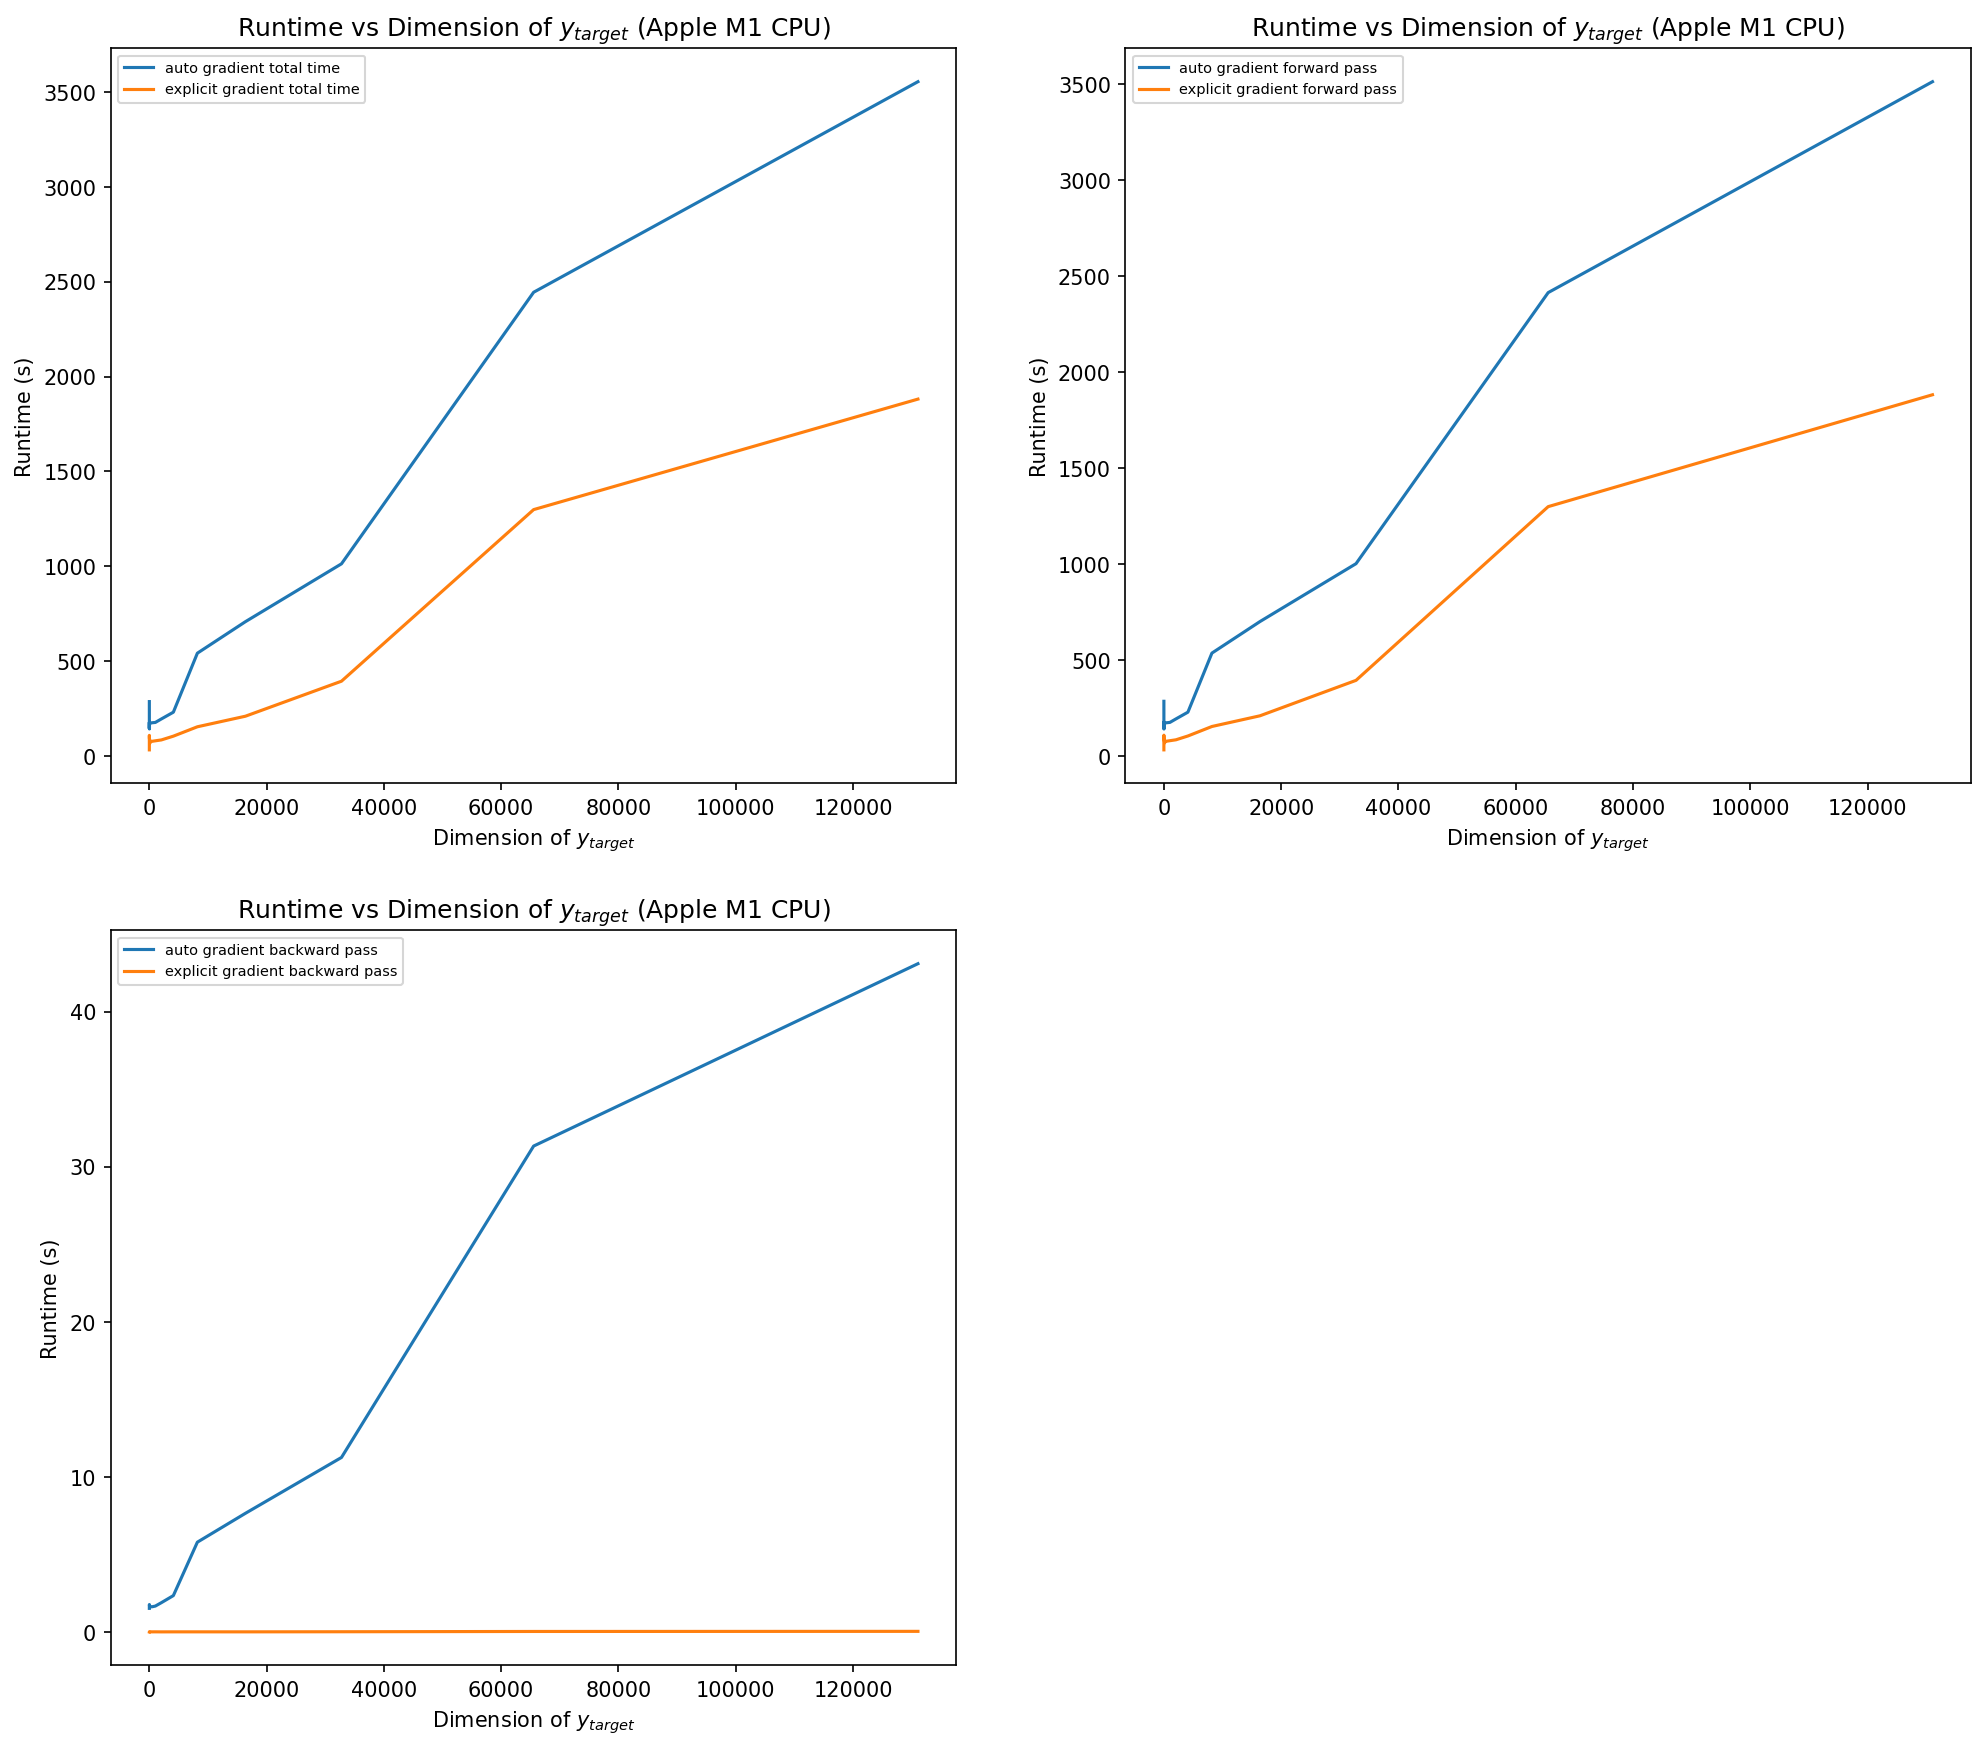

In [80]:
fig = plt.figure(figsize=(16, 14), dpi=150)
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222); ax3 = fig.add_subplot(223)

ax1.plot(dimensions, auto_grad_total_time,     label="auto gradient total time")
ax1.plot(dimensions, explicit_grad_total_time, label="explicit gradient total time")
ax1.set_xlabel("Dimension of $y_{target}$")
ax1.set_ylabel("Runtime (s)")
ax1.set_title("Runtime vs Dimension of $y_{target}$ (Apple M1 CPU)")
ax1.legend(fontsize=7)

ax2.plot(dimensions, auto_grad_forward_time,     label="auto gradient forward pass")
ax2.plot(dimensions, explicit_grad_forward_time, label="explicit gradient forward pass")
ax2.set_xlabel("Dimension of $y_{target}$")
ax2.set_ylabel("Runtime (s)")
ax2.set_title("Runtime vs Dimension of $y_{target}$ (Apple M1 CPU)")
ax2.legend(fontsize=7)

ax3.plot(dimensions, auto_grad_backward_time,     label="auto gradient backward pass")
ax3.plot(dimensions, explicit_grad_backward_time, label="explicit gradient backward pass")
ax3.set_xlabel("Dimension of $y_{target}$")
ax3.set_ylabel("Runtime (s)")
ax3.set_title("Runtime vs Dimension of $y_{target}$ (Apple M1 CPU)")
ax3.legend(fontsize=7)

plt.show()